In [10]:
# from future import print_function
import os
import torch
import torch.optim as optim
import torch.backends.cudnn as cudnn
import argparse
import torch.utils.data as data
import sys
sys.path.append(os.path.abspath(".."))
from data import WiderFaceDetection, detection_collate, preproc, cfg_mnet, cfg_re50
from layers.modules import MultiBoxLoss
from layers.functions.prior_box import PriorBox
import time
import datetime
import math
from models.retinaface import RetinaFace
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2

In [11]:
if torch.backends.mps.is_available():
    device = "mps"
elif torch.cuda.is_available():
    device = "cuda:0"
else:
    device = "cpu"

print(f"Using device: {device}")

Using device: mps


In [12]:
# Declare config (use resnet50 backbone)
cfg = cfg_re50
rgb_mean = (104, 117, 123) # bgr order
num_classes = 2
img_dim = cfg['image_size']
num_gpu = cfg['ngpu']
batch_size = cfg['batch_size']
max_epoch = cfg['epoch']
gpu_train = cfg['gpu_train']

initial_lr = 1e-3
momentum = 0.9
weight_decay = 5e-4

In [13]:
csv_file = "../data/fairface/fairface_label_train.csv"
df = pd.read_csv(csv_file)

# Separate male and female images
female_images = df[df["gender"] == 'Female']['file'].tolist()
male_images = df[df['gender'] == 'Male']['file'].tolist()

black_images = df[df["race"] == 'Black']['file'].tolist()
white_images = df[df["race"] == 'White']['file'].tolist()
indian_images = df[df["race"] == 'Indian']['file'].tolist()

print(f"Number of Female Images: {len(female_images)}")
print(f"Number of Male Images: {len(male_images)}")
print(f"Number of Black Images: {len(black_images)}")
print(f"Number of White Images: {len(white_images)}")

Number of Female Images: 40758
Number of Male Images: 45986
Number of Black Images: 12233
Number of White Images: 16527


In [14]:
# Instantiate model with the configurations above
def check_keys(model, pretrained_state_dict):
    ckpt_keys = set(pretrained_state_dict.keys())
    model_keys = set(model.state_dict().keys())
    used_pretrained_keys = model_keys & ckpt_keys
    unused_pretrained_keys = ckpt_keys - model_keys
    missing_keys = model_keys - ckpt_keys
    print('Missing keys:{}'.format(len(missing_keys)))
    print('Unused checkpoint keys:{}'.format(len(unused_pretrained_keys)))
    print('Used keys:{}'.format(len(used_pretrained_keys)))
    assert len(used_pretrained_keys) > 0, 'load NONE from pretrained checkpoint'
    return True

def remove_prefix(state_dict, prefix):
    ''' Old style model is stored with all names of parameters sharing common prefix 'module.' '''
    print('remove prefix \'{}\''.format(prefix))
    f = lambda x: x.split(prefix, 1)[-1] if x.startswith(prefix) else x
    return {f(key): value for key, value in state_dict.items()}

def load_model(model, pretrained_path, load_to_cpu):
    print('Loading pretrained model from {}'.format(pretrained_path))
    if load_to_cpu:
        pretrained_dict = torch.load(pretrained_path, map_location=lambda storage, loc: storage)
    else:
        pretrained_dict = torch.load(pretrained_path, map_location=device)
    if "state_dict" in pretrained_dict.keys():
        pretrained_dict = remove_prefix(pretrained_dict['state_dict'], 'module.')
    else:
        pretrained_dict = remove_prefix(pretrained_dict, 'module.')
    check_keys(model, pretrained_dict)
    model.load_state_dict(pretrained_dict, strict=False)
    return model

model = RetinaFace(cfg=cfg, phase="test").to(device)
model = load_model(model, "../Resnet50_Final.pth", False)
model.eval()

/Users/calvin/Documents/smu/Y3S2/CS427/CS427/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/calvin/Documents/smu/Y3S2/CS427/CS427/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading pretrained model from ../Resnet50_Final.pth
remove prefix 'module.'
Missing keys:0
Unused checkpoint keys:0
Used keys:456


RetinaFace(
  (body): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Seque

In [40]:
from utils.nms.py_cpu_nms import py_cpu_nms
from utils.box_utils import decode, decode_landm

def test_forward_pass(image_path, model, confidence_threshold):
    resize = 1
    img_raw = cv2.imread(image_path, cv2.IMREAD_COLOR)

    img = np.float32(img_raw)

    im_height, im_width, _ = img.shape
    scale = torch.Tensor([img.shape[1], img.shape[0], img.shape[1], img.shape[0]])
    img -= (104, 117, 123)
    img = img.transpose(2, 0, 1)
    img = torch.from_numpy(img).unsqueeze(0)
    img = img.to(device)
    scale = scale.to(device)
    loc, conf, landms = model(img)  # forward pass

    priorbox = PriorBox(cfg, image_size=(im_height, im_width))
    priors = priorbox.forward()
    priors = priors.to(device)
    prior_data = priors.data

    boxes = decode(loc.data.squeeze(0), prior_data, cfg['variance'])
    boxes = boxes * scale / resize
    boxes = boxes.cpu().numpy()

    scores = conf.squeeze(0).data.cpu().numpy()[:, 1]
    landms = decode_landm(landms.data.squeeze(0), prior_data, cfg['variance'])

    scale1 = torch.Tensor([img.shape[3], img.shape[2], img.shape[3], img.shape[2],
                               img.shape[3], img.shape[2], img.shape[3], img.shape[2],
                               img.shape[3], img.shape[2]])
    scale1 = scale1.to(device)
    landms = landms * scale1 / resize
    landms = landms.cpu().numpy()

    # ignore low scores
    inds = np.where(scores > confidence_threshold)[0]
    boxes = boxes[inds]
    landms = landms[inds]
    scores = scores[inds]

    # keep top-K before NMSk
    top_k = 5000
    order = scores.argsort()[::-1][:top_k]
    boxes = boxes[order]
    landms = landms[order]
    scores = scores[order]

    # do NMS
    dets = np.hstack((boxes, scores[:, np.newaxis])).astype(np.float32, copy=False)
    nms_threshold = 0.4
    keep = py_cpu_nms(dets, nms_threshold)
    # keep = nms(dets, args.nms_threshold,force_cpu=args.cpu)
    dets = dets[keep, :]
    landms = landms[keep]

    # keep top-K faster NMS
    keep_top_k = 750
    dets = dets[:keep_top_k, :]
    landms = landms[:keep_top_k, :]

    dets = np.concatenate((dets, landms), axis=1)

    total_detected_faces = 0
    has_detected_face = False
    visualization_threshold = 0.6
    confidence_score = 0

    for b in dets:
        if b[4] < visualization_threshold:
            continue
        
        has_detected_face = True
        total_detected_faces += 1
        confidence_score += b[4]

        text = "{:.4f}".format(b[4])
        b = list(map(int, b))
        cv2.rectangle(img_raw, (b[0], b[1]), (b[2], b[3]), (0, 0, 255), 2)
        cx = b[0]
        cy = b[1] + 12
        cv2.putText(img_raw, text, (cx, cy),
                    cv2.FONT_HERSHEY_DUPLEX, 0.5, (255, 255, 255))

        # landms
        cv2.circle(img_raw, (b[5], b[6]), 1, (0, 0, 255), 4)
        cv2.circle(img_raw, (b[7], b[8]), 1, (0, 255, 255), 4)
        cv2.circle(img_raw, (b[9], b[10]), 1, (255, 0, 255), 4)
        cv2.circle(img_raw, (b[11], b[12]), 1, (0, 255, 0), 4)
        cv2.circle(img_raw, (b[13], b[14]), 1, (255, 0, 0), 4)
    
    # if total_detected_faces == 1:
    #     # save image
    #     base_file_name = os.path.basename(image_path)
    #     name = f"./Testing/{base_file_name}"
    #     cv2.imwrite(name, img_raw)

    if has_detected_face:
        return 1, confidence_score
    else:
        return 0, confidence_score

In [44]:
def computeFairness(folder_path):
    file_names = os.listdir(folder_path)

    total_detected_faces = 0
    total_confidence_score = 0
    for file_name in file_names:
        image_path = f"{folder_path}{file_name}"
        detected, confidence_score = test_forward_pass(image_path, model, 0.99)
        total_detected_faces += detected
        total_confidence_score += confidence_score
    
    accuracy = total_detected_faces / 100 * 100
    avg_confidence_score = total_confidence_score / 100
    return accuracy, avg_confidence_score

In [45]:
# Computing fairness for black race images
black_folder_path = "../data/fairface/filtered/black/"
accuracy_black, avg_confidence_score_black = computeFairness(black_folder_path)

print(f"Accuracy = {accuracy_black}")
print(f"Average confidence score = {avg_confidence_score_black}")

Accuracy = 98.0
Average confidence score = 0.9779000282287598


In [46]:
# Computing fairness for indian race images
indian_folder_path = "../data/fairface/filtered/indian/"
accuracy_indian, avg_confidence_score_indian = computeFairness(indian_folder_path)

print(f"Accuracy = {accuracy_indian}")
print(f"Average confidence score = {avg_confidence_score_indian}")

Accuracy = 100.0
Average confidence score = 0.9979908466339111


In [47]:
# Computing fairness for white race images
white_folder_path = "../data/fairface/filtered/white/"
accuracy_white, avg_confidence_score_white = computeFairness(white_folder_path)

print(f"Accuracy = {accuracy_white}")
print(f"Average confidence score = {avg_confidence_score_white}")

Accuracy = 100.0
Average confidence score = 0.9983798265457153


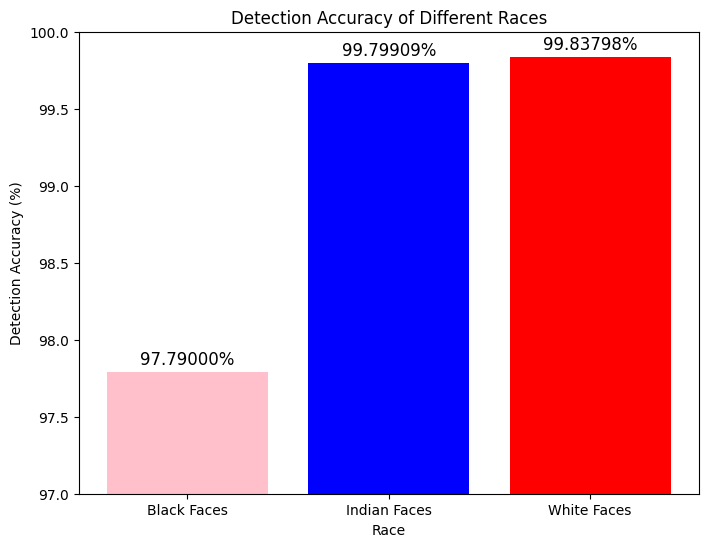

In [52]:
categories = ['Black Faces', 'Indian Faces', 'White Faces']
# accuracies = [accuracy_black, accuracy_indian, accuracy_white]
avg_confidence_score = [avg_confidence_score_black, avg_confidence_score_indian, avg_confidence_score_white]
avg_confidence_score = [x * 100 for x in avg_confidence_score]

plt.figure(figsize=(8,6))
plt.bar(categories, avg_confidence_score, color=['pink', 'blue', 'red'])
plt.xlabel('Race')
plt.ylabel('Detection Accuracy (%)')
plt.title('Detection Accuracy of Different Races')
plt.ylim(97,100)

for i, v in enumerate(avg_confidence_score):
    plt.text(i, v+0.05, f"{v:.5f}%", ha='center', fontsize=12)

plt.show()